<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Parking_spot_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classifier

We buid a modelto predict the parking spots, if they are empty or not.

[Data](https://drive.google.com/file/d/11DyZ165lZGzULEZSQNofyy9A8xaYgFJ2)

In [ ]:
import os
import cv2
import pickle
import shutil
import sklearn
import skimage
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn import metrics
from sklearn import model_selection

In [ ]:
zip_folder = '/content/drive/MyDrive/DATA/car-parking-slot-empty-notempty.zip'
shutil.copyfile(zip_folder, '/content/data.zip')
!unzip \*.zip && rm *.zip

In [ ]:
data = []
labels = []
for id, cat in enumerate(['empty', 'not_empty']):
  path = f'./clf-data/{cat}/'
  for img in os.listdir(path):
    img = skimage.io.imread(path+img)
    img = skimage.transform.resize(img, (15, 15))
    data.append(img.flatten())
    labels.append(id)

data = np.asarray(data)
labels = np.asarray(labels)

data.shape,labels.shape

((6090, 675), (6090,))

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=32)
x_train.shape, x_test.shape

In [ ]:
clf = svm.SVC()

parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]

grid_search = model_selection.GridSearchCV(clf, parameters)

In [ ]:
# grid_search.fit(x_train, y_train)

# # test performance
# best_estimator = grid_search.best_estimator_

# y_prediction = best_estimator.predict(x_test)

# score = metrics.accuracy_score(y_prediction, y_test)

# print('{}% of samples were correctly classified'.format(str(score * 100)))

# pickle.dump(best_estimator, open('./model.p', 'wb'))

100.0% of samples were correctly classified


#Parking Spot Detector

In [ ]:
MODEL = pickle.load(open("./drive/MyDrive/DATA/model.p", "rb"))

In [ ]:
def empty_or_not(spot_bgr):

    img_resized = skimage.transform.resize(spot_bgr, (15, 15, 3))
    pred = MODEL.predict(np.array([img_resized.flatten()]))
    return True if pred == 0 else False

In [ ]:
def get_parking_spots_bboxes(connected_components, coef=1):
    (totalLabels, label_ids, values, centroid) = connected_components

    slots = []
    for i in range(1, totalLabels):

        # Now extract the coordinate points
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)

        slots.append([x1, y1, w, h])

    return slots

In [ ]:
calc_diff = lambda im1, im2: np.abs(np.mean(im1) - np.mean(im2))

In [ ]:
mask = './mask_1920_1080.png'
video_path = './samples/parking_1920_1080_loop.mp4'


mask = cv2.imread(mask, 0)

cap = cv2.VideoCapture(video_path)

connected_components = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

spots = get_parking_spots_bboxes(connected_components)

spots_status = [None for j in spots]
diffs = [None for j in spots]

previous_frame = None

frame_nmr = 0
ret = True
step = 30
while ret:
    ret, frame = cap.read()

    if frame_nmr % step == 0 and previous_frame is not None:
        for spot_indx, spot in enumerate(spots):
            x1, y1, w, h = spot

            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]

            diffs[spot_indx] = calc_diff(spot_crop, previous_frame[y1:y1 + h, x1:x1 + w, :])

        print([diffs[j] for j in np.argsort(diffs)][::-1])

    if frame_nmr % step == 0:
        if previous_frame is None:
            arr_ = range(len(spots))
        else:
            arr_ = [j for j in np.argsort(diffs) if diffs[j] / np.amax(diffs) > 0.4]
        for spot_indx in arr_:
            spot = spots[spot_indx]
            x1, y1, w, h = spot

            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]

            spot_status = empty_or_not(spot_crop)

            spots_status[spot_indx] = spot_status

    if frame_nmr % step == 0:
        previous_frame = frame.copy()

    for spot_indx, spot in enumerate(spots):
        spot_status = spots_status[spot_indx]
        x1, y1, w, h = spots[spot_indx]

        if spot_status:
            frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)
        else:
            frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 0, 255), 2)

    cv2.rectangle(frame, (80, 20), (550, 80), (0, 0, 0), -1)
    cv2.putText(frame, 'Available spots: {} / {}'.format(str(sum(spots_status)), str(len(spots_status))), (100, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
    cv2.imshow('frame', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    frame_nmr += 1

cap.release()
cv2.destroyAllWindows()

#New
[pklotsdbs](https://www.kaggle.com/datasets/blanderbuss/parking-lot-dataset)

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import model_selection
from IPython.display import clear_output

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d blanderbuss/parking-lot-dataset
!unzip \*.zip && rm *.zip
clear_output()

#Yolo V8

In [ ]:
#install necessary libraries
!pip install awscli
!pip install ultralytics
clear_output()

In [ ]:
cls_data = './PKLot/PKLotSegmented'
train_path_1 = './data/train/Empty/'
train_path_2 = './data/train/Occupied/'
val_path_1   = './data/validation/Empty/'
val_path_2   = './data/validation/Occupied/'

os.makedirs(train_path_1, exist_ok=True)
os.makedirs(val_path_1, exist_ok=True)
os.makedirs(train_path_2, exist_ok=True)
os.makedirs(val_path_2, exist_ok=True)

VAL_THRESHOLD = 0.2
data_arr = []

for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O):
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = 'train' if np.random.randn()<VAL_THRESHOLD else 'validation'
          target = os.path.join('./data', folder_name, E_O, img)
          label = 0 if E_O == 'Empty' else 1
          data_arr.append([target, label])
          os.replace(path, target)
          break

data = pd.DataFrame(data_arr, columns=['path', 'label'])
data

,path,label
0,./data/train/Empty/2013-03-16_11_45_06#017.jpg,0
1,./data/train/Occupied/2013-03-16_13_20_08#023.jpg,1
2,./data/train/Empty/2013-02-26_15_54_36#009.jpg,0
3,./data/validation/Occupied/2013-02-26_15_09_35...,1
4,./data/validation/Empty/2013-03-02_12_55_08#03...,0
...,...,...
257,./data/train/Occupied/2012-11-10_10_42_50#039.jpg,1
258,./data/train/Empty/2012-10-25_17_38_48#004.jpg,0
259,./data/train/Occupied/2012-10-25_15_33_41#022.jpg,1
260,./data/train/Empty/2012-09-16_07_12_57#076.jpg,0


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')
model.train(data='./data', epochs = 10, device='cpu', seed=32)

In [ ]:
from ultralytics import YOLO

# model = YOLO('yolov8n.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights
model = YOLO('yolov8n-cls.pt')
model.train(data='./data', epochs = 10, device='cpu', seed=32)

#Classification

In [31]:
cls_data = './PKLot/PKLotSegmented'
train_path = './data/train'
val_path   = './data/validation'
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

VAL_THRESHOLD = 0.2

In [32]:
limit = 5
data_arr = []

for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O)[:limit]:
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = train_path if np.random.randn()<VAL_THRESHOLD else val_path
          target = os.path.join(folder_name, img)
          label = 0 if E_O == 'Empty' else 1
          data_arr.append([target, label])
          os.replace(path, target)


data = pd.DataFrame(data_arr, columns=['path', 'label'])
data

,path,label
0,./data/train/2013-01-20_20_35_16#013.jpg,0
1,./data/train/2013-01-20_18_00_13#017.jpg,0
2,./data/train/2013-01-20_09_35_05#001.jpg,0
3,./data/train/2013-01-20_17_40_13#019.jpg,0
4,./data/train/2013-01-20_12_25_08#001.jpg,0
...,...,...
997,./data/train/2013-04-10_13_30_08#012.jpg,1
998,./data/validation/2013-04-10_15_50_11#019.jpg,1
999,./data/train/2013-04-10_08_40_03#005.jpg,1
1000,./data/validation/2013-04-10_11_55_06#030.jpg,1


In [33]:
data.groupby(['label']).count()

,path
label,
0,507
1,495


In [35]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory('./data',
                                                               validation_split=0.2,
                                                               subset='both',
                                                               seed=32,
                                                               image_size=(150, 150),
                                                               batch_size=32)

Found 1002 files belonging to 2 classes.
Using 802 files for training.
Using 200 files for validation.


In [ ]:
def show_images(ds, augmentation=False):
  plt.figure(figsize=(3, 3))
  for images, labels in ds.take(1):
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          if augmentation:
            images = data_augmentation(images)
            i = 0
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(int(labels[i]))
          plt.axis("off")

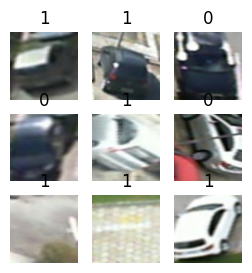

In [ ]:
show_images(train_ds)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
    ], name="img_augmentation")

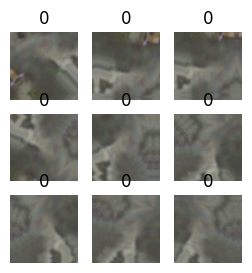

In [ ]:
show_images(train_ds, augmentation=True)

###model 1

In [ ]:
augmented_train_ds = train_ds.map(lambda img, label : (data_augmentation(img), label),
                                  num_parallel_calls=tf.data.AUTOTUNE)

#(buffered) Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def Model(input_shape, num_cls):
  inputs = tf.keras.Input(shape=input_shape)
  x = tf.keras.layers.Rescaling(1/255)(inputs)
  x = layers = tf.keras.layers.Conv2D(128, 3, strides=3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #Set Aside residual
  previous_block_activation = x

  for size in [256, 512, 728]:
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

    x = tf.keras.layers.add([x, residual])
    previous_block_activation = x

  x = tf.keras.layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  if num_cls == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_cls

  x  = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(units, activation=activation)(x)
  return tf.keras.Model(inputs, outputs)

In [ ]:
model = Model(input_shape=train_ds.take(1).element_spec[0].shape[1:], num_cls=2)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile
epochs = 2
num_cls = 2
IMG_SIZE = 528
to_Dropout_rate = 0.2
callbacks = [tf.keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')]

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=val_ds)

Epoch 1/2


###model 2

In [ ]:
# EfficientNetB6 input dim = 528
# EfficientNetB0 input dim = 224
# EfficientNetB3 input dim = 300
# VGG16 input dim = 224

epochs = 10
num_cls = 1
IMG_SIZE = 224
to_Dropout_rate = 0.2
callbacks = [tf.keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')]

inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
# x = inputs.copy()
x = data_augmentation(inputs)
model = tf.keras.applications.ResNet50V2(include_top=True, input_tensor=x, weights='imagenet')

model.trainable=False

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(model.input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(to_Dropout_rate, name='top_dropout')(x)
outputs = tf.keras.layers.Dense(num_cls, activation='softmax', name='pred')(x)

model = tf.keras.Model(inputs, outputs, name='model')
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adamax(),
              loss = tf.keras.losses.BinaryCrossentropy(
              from_logits=False,
              label_smoothing=0.0,
              axis=-1,
              reduction="auto",
              name="binary_crossentropy"),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.AUC(
                                            num_thresholds=200,
                                            curve="ROC",
                                            summation_method="interpolation",
                                            name=None,
                                            dtype=None,
                                            thresholds=None,
                                            multi_label=False,
                                            num_labels=None,
                                            label_weights=None,
                                            from_logits=False),
                        tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)])

hist = model.fit(train_ds,
          epochs=4,
          callbacks=callbacks,
          validation_data=val_ds)


Epoch 1/4
67/67 [==============================] - 5s 55ms/step - loss: 0.8226 - binary_accuracy: 0.4282 - auc: 0.5000 - precision: 0.4282 - val_loss: 1.2340 - val_binary_accuracy: 0.4135 - val_auc: 0.5000 - val_precision: 0.4135
Epoch 2/4
67/67 [==============================] - 5s 69ms/step - loss: 0.7893 - binary_accuracy: 0.4282 - auc: 0.5000 - precision: 0.4282 - val_loss: 0.8331 - val_binary_accuracy: 0.4135 - val_auc: 0.5000 - val_precision: 0.4135
Epoch 3/4
67/67 [==============================] - 4s 59ms/step - loss: 0.7692 - binary_accuracy: 0.4282 - auc: 0.5000 - precision: 0.4282 - val_loss: 0.7441 - val_binary_accuracy: 0.4135 - val_auc: 0.5000 - val_precision: 0.4135
Epoch 4/4
67/67 [==============================] - 5s 67ms/step - loss: 0.7661 - binary_accuracy: 0.4282 - auc: 0.5000 - precision: 0.4282 - val_loss: 0.7124 - val_binary_accuracy: 0.4135 - val_auc: 0.5000 - val_precision: 0.4135


### model 3

In [42]:
def Model(input_shape, num_cls=2):

  inputs = tf.keras.Input(shape=input_shape)
  x = tf.keras.layers.Rescaling(1/255)(inputs)
  x = layers = tf.keras.layers.Conv2D(128, 3, strides=3, padding='same', name='conv1')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = layers = tf.keras.layers.Conv2D(128, 3, strides=3, padding='same', name='conv2')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = layers = tf.keras.layers.Conv2D(64, 3, strides=3, padding='same', name='conv3')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = layers = tf.keras.layers.Conv2D(32, 3, strides=3, padding='same', name='conv4')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = layers = tf.keras.layers.Conv2D(16, 3, strides=3, padding='same', name='conv5')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  # x = tf.keras.layers.Activation('relu')(x)
  # x = tf.keras.layers.SeparableConv2D(128, 3, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)

  # x = tf.keras.layers.Activation('relu')(x)
  # x = tf.keras.layers.SeparableConv2D(256, 3, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)

  # x = tf.keras.layers.Activation('relu')(x)
  # x = tf.keras.layers.SeparableConv2D(256, 3, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)

  # x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
  # residual = tf.keras.layers.Conv2D(256, 1, strides=2, padding='same')(previous_block_activation)

  # x = tf.keras.layers.SeparableConv2D(1024, 3, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  # x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Flatten()(x)
  # x  = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  return tf.keras.Model(inputs, outputs)

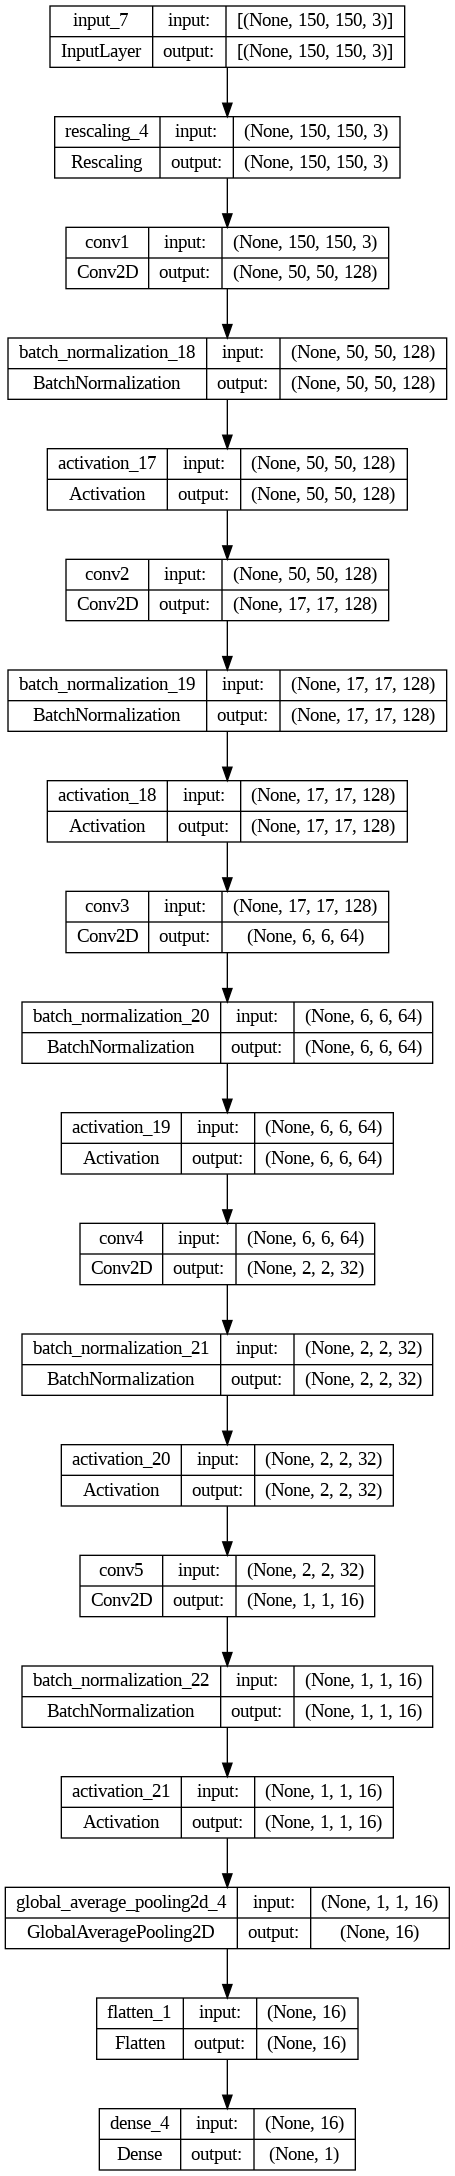

In [43]:
model = Model(input_shape=train_ds.take(1).element_spec[0].shape[1:], num_cls=2)
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
# Compile
epochs = 2
to_Dropout_rate = 0.2
callbacks = [tf.keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')]

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=val_ds)

Epoch 1/2
256/256 [==============================] - 558s 2s/step - loss: 0.7233 - accuracy: 0.5418 - val_loss: 0.6756 - val_accuracy: 0.5953
Epoch 2/2
256/256 [==============================] - 530s 2s/step - loss: 0.6873 - accuracy: 0.5696 - val_loss: 0.6767 - val_accuracy: 0.5953


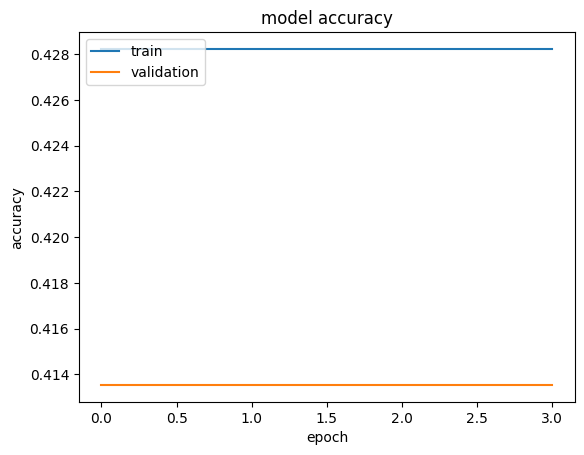

In [29]:
def plot_hist(hist, acc='binary_accuracy'):
    plt.plot(hist.history[f"{acc}"])
    plt.plot(hist.history[f"val_{acc}"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adamax(),
              loss = tf.keras.losses.BinaryCrossentropy(
              from_logits=False,
              label_smoothing=0.0,
              axis=-1,
              reduction="auto",
              name="binary_crossentropy"),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.AUC(
                                            num_thresholds=200,
                                            curve="ROC",
                                            summation_method="interpolation",
                                            name=None,
                                            dtype=None,
                                            thresholds=None,
                                            multi_label=False,
                                            num_labels=None,
                                            label_weights=None,
                                            from_logits=False),
                        tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)])

hist = model.fit(train_ds,
          epochs=4,
          callbacks=callbacks,
          validation_data=val_ds)

Epoch 1/4


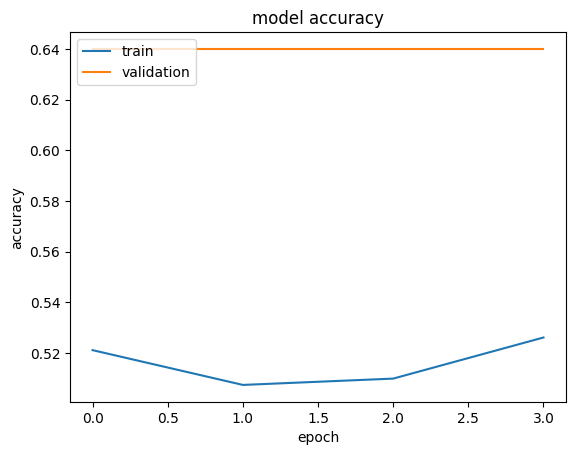

In [39]:
def plot_hist(hist, acc='binary_accuracy'):
    plt.plot(hist.history[f"{acc}"])
    plt.plot(hist.history[f"val_{acc}"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

### res

In [ ]:
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
# hist.history

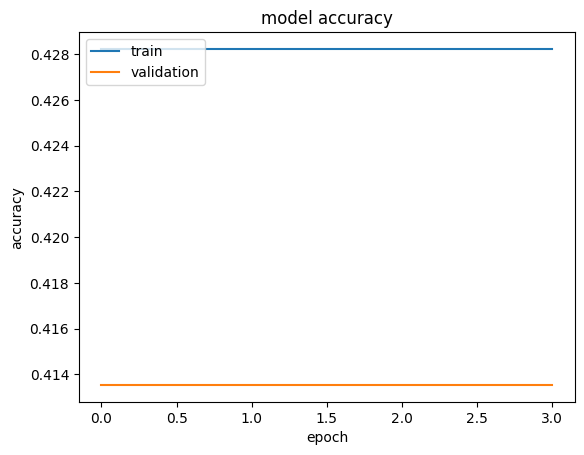

In [ ]:
def plot_hist(hist, acc='binary_accuracy'):
    plt.plot(hist.history[f"{acc}"])
    plt.plot(hist.history[f"val_{acc}"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
# from cloud_tpu_client import Client
# c = Client()
# c.configure_tpu_version(tf.__version__, restart_type="always")
# import tensorflow as tf

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     print("Device:", tpu.master())
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError:
#     print("Not connected to a TPU runtime. Using CPU/GPU strategy")
#     strategy = tf.distribute.MirroredStrategy()

In [ ]:
img = tf.keras.utils.load_img('./dfdf.jpg', target_size=(IMG_SIZE, IMG_SIZE, 3))
plt.imshow(img)

img_arr = tf.keras.utils.img_to_array(img)
img_arr = tf.expand_dims(img_arr, 0) # Create batch axis

pred = model.predict(img_arr)
score = float(pred[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [ ]:
#Unfreeze some layers
for layer in model.layers[-20:]:
  if not isinstance(layer, tf.keras.layers.BatchNormalization):
    layer.trainable = True

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)
plot_hist(hist)